In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as Fun
import random
import pickle as pkl
import gzip

import games
import synthetic_data

In [2]:
class Evaluate:

    def __init__(self, ):
        pass

    def get_feedback(self, game, action, outcome ):
        return game.FeedbackMatrix[ action ][ outcome ]
        
    def deploy(self, game, horizon, alg, context_generator):

        history = [] 
        cumRegret =  []
        t = 0
        global_loss = []
        global_losses = []
        
        for t in range(horizon):
            
            context, distribution = context_generator.get_context()
            context = context.reshape( (1, -1) )
            outcome = 0 if distribution[0]<0.5 else 1
            # distribution = np.array([1-outcome, outcome])
            print('distribution', distribution, 'outcome', outcome, )

            print('context shape',context.shape)
            action, data = alg.get_action(t, context)

            data['context'] = context 
            history.append( data )

            
            feedback =  self.get_feedback( game, action, outcome )

            loss, losses = alg.update(action, feedback, outcome, t, context )

            global_loss.append(loss)
            global_losses.append(losses)

            i_star = np.argmin(  [ game.LossMatrix[i,...] @ np.array( distribution ) for i in range(alg.N) ]  )
            loss_diff = game.LossMatrix[action,...] - game.LossMatrix[i_star,...]
            val = loss_diff @ np.array( distribution )
            cumRegret.append( val )
            t+=1

            print('t', t, 'action', action, 'outcome', outcome, 'regret',val)
            
        return history, cumRegret, global_loss, global_losses

In [34]:
import cbpside
import rand_cbpside
import randneuralcbp_LE
import cesa_bianchi
import random_algo
import ineural
import ineural_multi
import margin_based

seed = 3
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

m = 20
H = 200
horizon = 2000

##### train and test data:

context_generator = synthetic_data.MNISTcontexts_binary()
# synthetic_data.QuinticContexts(  )
# context_generator = synthetic_data.QuinticContexts_imbalanced(  )
# context_generator.set_b(0)
# context_generator.normalization()

game = games.label_efficient( )

# alg = random_algo.Egreedy(game, horizon, 'cuda:0')
# alg.reset(context_generator.d)

# alg = cesa_bianchi.CesaBianchi(game, m, 'cuda:0')

lbd_neural = 0
lbd_reg = 1
sigma = 1/2
K = 100
epsilon = 10e-7
alg = randneuralcbp_LE.CBPside( game, 1.01, lbd_neural, lbd_reg, sigma, K, epsilon, m, H,  'cuda:0')
alg.reset(context_generator.d)

# alg = ineural.INeurAL('cuda:0', horizon, 2)
# alg.reset(context_generator.d)

# budget = 9999
# nclasses = 2
# alg = ineural_multi.INeurALmulti(budget, nclasses, 'cuda:0')
# alg.reset(context_generator.d)

# alg = margin_based.MarginBased(game, m, 0.1,  'cuda:0')
# alg.reset(context_generator.d)

evaluator = Evaluate()

In [35]:
history, cumRegret, global_loss, global_losses = evaluator.deploy(game, horizon, alg, context_generator)

distribution [0, 1] outcome 0
context shape (1, 784)
t 1 action 0 outcome 0 regret 1
distribution [0, 1] outcome 0
context shape (1, 784)
t 2 action 1 outcome 0 regret 0
distribution [0, 1] outcome 0
context shape (1, 784)
t 3 action 2 outcome 0 regret 1
distribution [1, 0] outcome 1
context shape (1, 784)
0 0.5615421908765893 0.46436971462593685
union1 [1 2] R [0]
t 4 action 0 outcome 1 regret 1
distribution [0, 1] outcome 0
context shape (1, 784)
0 0.6760735889259554 0.35473256751132826
union1 [1 2] R [0]
t 5 action 0 outcome 0 regret 1
distribution [0, 1] outcome 0
context shape (1, 784)
union1 [1] R []
t 6 action 1 outcome 0 regret 0
distribution [1, 0] outcome 1
context shape (1, 784)
union1 [1] R []
t 7 action 1 outcome 1 regret 1
distribution [0, 1] outcome 0
context shape (1, 784)
0 0.5085693411868221 0.21816575817592915
union1 [1 2] R [0]
t 8 action 0 outcome 0 regret 1
distribution [1, 0] outcome 1
context shape (1, 784)
0 0.3922446572744837 0.19521685512266798
union1 [1 2] R

In [7]:
import torch
from torchvision import datasets, transforms

# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)) ])
# test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
# test_loader = list(test_loader)
# index = 0
# x, y = test_loader[index]
# x = x.flatten()
x.shape[0]

784

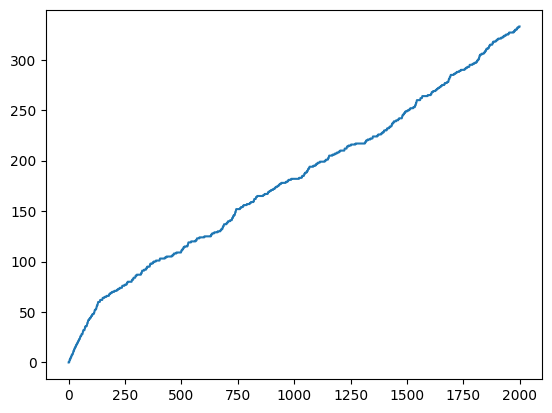

In [5]:
plt.plot( np.cumsum(cumRegret) )

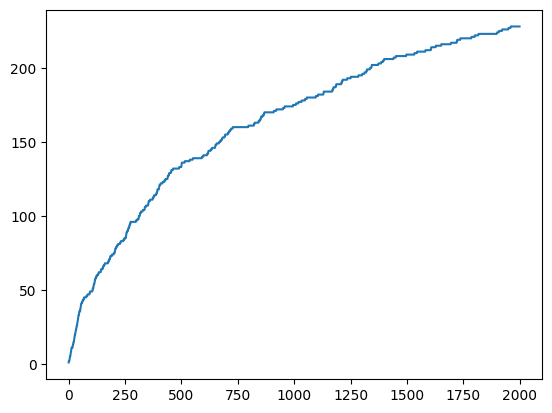

In [29]:
plt.plot( np.cumsum(cumRegret) )

In [7]:
vals = []
for j in range(1,10):
    val = 0
    for i in range(1, j+1):
        val += 9 * (9/10)**i
    vals.append(val)
vals 


[8.1,
 15.39,
 21.951,
 27.855900000000002,
 33.17031,
 37.953279,
 42.2579511,
 46.13215599,
 49.618940391]

In [13]:
result = [history, cumRegret]

with gzip.open( './results/LE_{}_{}.pkl.gz'.format(alg.name, horizon) ,'wb') as f:
    pkl.dump(result,f)

In [14]:
horizon = 20000

with gzip.open( './results/LE_{}_{}.pkl.gz'.format('random',  horizon) ,'rb') as f:
    result1 = pkl.load(f)

with gzip.open( './results/LE_{}_{}.pkl.gz'.format('cesabianchi',  horizon) ,'rb') as f:
    result2 = pkl.load(f)

with gzip.open( './results/LE_{}_{}.pkl.gz'.format('randneuralcbp',  horizon) ,'rb') as f:
    result3 = pkl.load(f)

with gzip.open( './results/LE_{}_{}.pkl.gz'.format('ineural',  horizon) ,'rb') as f:
    result4 = pkl.load(f)

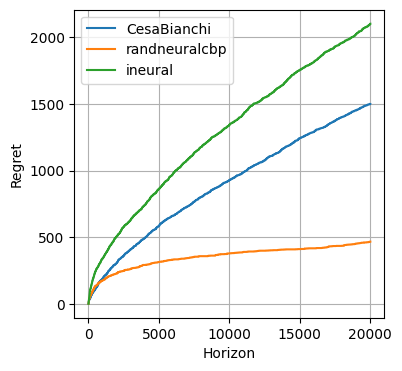

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
# plt.plot(np.cumsum(result1[1]), label = 'random', color = 'black')
plt.plot(np.cumsum(result2[1]), label = 'CesaBianchi')
plt.plot(np.cumsum(result3[1]), label = 'randneuralcbp')
plt.plot(np.cumsum(result4[1]), label = 'ineural')
plt.legend()
# plt.yscale('log')
plt.ylabel('Regret')
plt.xlabel('Horizon')
plt.grid()
# plt.ylim((0,1000))
# plt.xlim((0,2000))
plt.savefig('./figures/LE_results2.png', dpi=380, bbox_inches='tight')
# plt.savefig('./figures/CBP_regret4.png', dpi=380, bbox_inches='tight')
# plt.savefig('./figures/{}_regret4.png'.format(alg.name), dpi=380, bbox_inches='tight')

In [5]:
train_hist = [sublist for sublist in history if sublist[3] is False]
depl_hist = [sublist for sublist in history if sublist[3] is True]

KeyError: 3

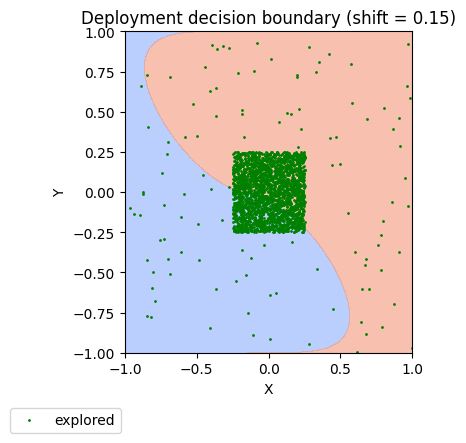

In [14]:
# Define the range of x and y values for the grid
x_min, x_max = -1, 1
y_min, y_max = -1, 1

# Generate a grid of points
num_points = 1000
x_values = np.linspace(x_min, x_max, num_points)  
y_values = np.linspace(y_min, y_max, num_points)  
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Compute the decision boundary for the grid of points
b = 0.15

plt.figure(figsize=(4, 4))

decision_boundary_grid = context_generator.decision_boundary_function(x_grid, y_grid, b)
plt.contourf(x_grid, y_grid, decision_boundary_grid, levels=1, alpha=0.6, cmap=plt.cm.coolwarm)

contexts = np.array( [ context_generator.denormalize(i[4]) for i in train_hist ] ).squeeze(1) 

action0 = [ i[0] if i[0]==2 else np.nan for i in train_hist ]
indices_action0 = np.where(~np.isnan(action0))[0]
contexts0 = contexts[indices_action0]

action1 = [ i[0] if i[0]==1 else np.nan for i in train_hist ]
indices_action1 = np.where(~np.isnan(action1))[0]
contexts1 = contexts[indices_action1]

action2 = [ i[0] if i[0]==0 else np.nan for i in train_hist ]
indices_action2 = np.where(~np.isnan(action2))[0]
contexts2 = contexts[indices_action2]

# plt.plot(contexts0[:,0], contexts0[:,1], '.', color = 'orange', markersize = 2, label = 'predicted as class 1')
# plt.plot(contexts1[:,0], contexts1[:,1], '.', color = 'blue', markersize = 2, label = 'predicted as class 2')
plt.plot(contexts2[:,0], contexts2[:,1], '.', color = 'green', markersize = 2, label = 'explored')

plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.ylim((-1,1))
plt.xlim((-1,1))
# plt.title('Training decision boundary (shift = {})'.format(b))
plt.title('Deployment decision boundary (shift = {})'.format(b))
plt.legend(loc = (-0.4,-0.25),ncol = 3)
# Save the figure to a file with tight layout and 380 DPI
# plt.savefig('./figures/CBP_DB_{}.png'.format(b), dpi=380, bbox_inches='tight')
plt.savefig('./figures/ETC_exploration3_{}.png'.format(b), dpi=380, bbox_inches='tight')
# plt.savefig('./figures/CBP_exploration3_{}.png'.format(b), dpi=380, bbox_inches='tight')

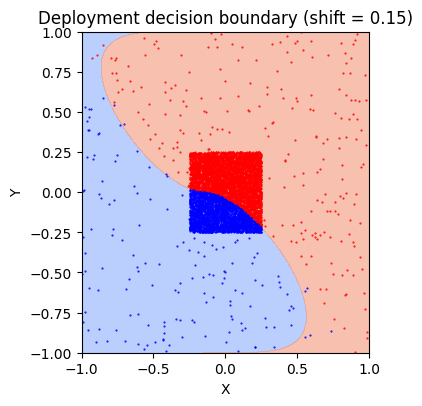

In [15]:
# Define the range of x and y values for the grid
x_min, x_max = -1, 1
y_min, y_max = -1, 1

# Generate a grid of points
num_points = 1000
x_values = np.linspace(x_min, x_max, num_points)  
y_values = np.linspace(y_min, y_max, num_points)  
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Compute the decision boundary for the grid of points
for b in [0.15]: #[0, 0.15]

    plt.figure(figsize=(4, 4))

    decision_boundary_grid = context_generator.decision_boundary_function(x_grid, y_grid, b)

    plt.contourf(x_grid, y_grid, decision_boundary_grid, levels=1, alpha=0.6, cmap=plt.cm.coolwarm)

    contexts = np.array( [ context_generator.denormalize(i[4]) for i in depl_hist ] ).squeeze(1) 

    action0 = [ i[0] if i[0]==2 else np.nan for i in depl_hist ]
    indices_action0 = np.where(~np.isnan(action0))[0]
    contexts0 = contexts[indices_action0]
    action1 = [ i[0] if i[0]==1 else np.nan for i in depl_hist ]
    indices_action1 = np.where(~np.isnan(action1))[0]
    contexts1 = contexts[indices_action1]

    plt.plot(contexts0[:,0], contexts0[:,1], '.', markersize = 1, color = 'red')
    plt.plot(contexts1[:,0], contexts1[:,1], '.', markersize = 1, color = 'blue')

    # plt.scatter(contexts[indices_predaction0][:,0], contexts[indices_predaction0][:,1], s = 1, color='blue', label='Predicted Points')
    # plt.scatter(contexts[indices_predaction1][:,0], contexts[indices_predaction1][:,1], s = 1, color='red', label='Predicted Points')

    # Add labels and title to the plot
    plt.xlabel('X')
    plt.ylabel('Y')
    # plt.title(' Decision Boundary')
    # Adjust the layout for better spacing
    plt.tight_layout()
    plt.ylim((-1,1))
    plt.xlim((-1,1))
    plt.title('Deployment decision boundary (shift = {})'.format(b))

    # Save the figure to a file with tight layout and 380 DPI
    plt.savefig('./figures/ETC_exploitation3_{}.png'.format(b), dpi=380, bbox_inches='tight')
    # plt.savefig('./figures/CBP_exploitation3_{}.png'.format(b), dpi=380, bbox_inches='tight')

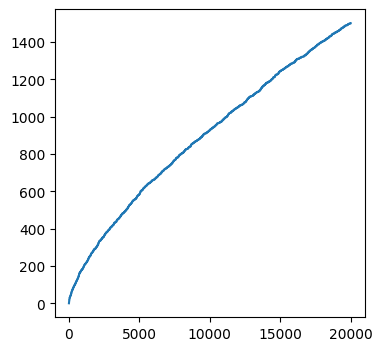

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
plt.plot(np.cumsum(cumRegret))
# plt.ylim((0,3000))
# plt.savefig('./figures/ETC_regret3.png', dpi=380, bbox_inches='tight')
# plt.savefig('./figures/CBP_regret3.png', dpi=380, bbox_inches='tight')

In [18]:
from matplotlib.ticker import ScalarFormatter

new_global_loss = np.hstack( [ i for i in global_loss if len(i)>0 ] )

plt.figure(figsize=(8, 4))
# plt.ylim( (0, 10) )
plt.yscale('log')
plt.grid(color='gray', linestyle='-')
plt.xlim( (-10, len(new_global_loss)) )


def generate_custom_ticks(start, horizon, end, increment, label_increment):
    custom_ticks = list(range(start, end+1 , increment))
    custom_tick_labels = [ str(i) for i in range(start, horizon , label_increment)]
    return custom_ticks, custom_tick_labels

# Define the parameters
start_value = 0
end_value = len(new_global_loss) 
tick_increment = 1000
label_increment = 50
horizon = 1000

custom_ticks, custom_tick_labels = generate_custom_ticks(start_value, horizon, end_value, tick_increment, label_increment)

plt.xticks(custom_ticks, custom_tick_labels, rotation=45, fontsize=7)

# Set tick locations and labels for the y-axis
tick_locations = [0.01, 0.1, 1, 10,]  # Define your desired tick locations
tick_labels = ['0.01', '0.1', '1', '10', ]  # Corresponding labels
ax = plt.gca()
ax.yaxis.set_major_locator(plt.FixedLocator(tick_locations))
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_yticklabels(tick_labels)

plt.plot( new_global_loss )
plt.xlabel('Step + 1000 epochs')
plt.ylabel('Loss')

# plt.savefig('./figures/loss_evolution.png', dpi=380, bbox_inches='tight')


TypeError: object of type 'NoneType' has no len()

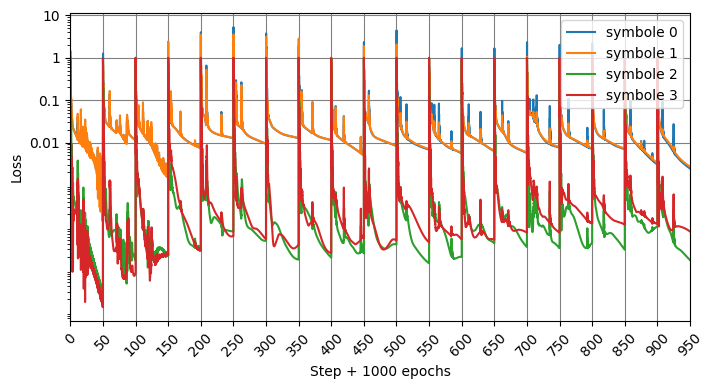

In [29]:
from matplotlib.ticker import ScalarFormatter

new_global_loss = np.vstack( [ i for i in global_losses if len(i)>0 ] )

plt.figure(figsize=(8, 4))

plt.yscale('log')
plt.grid(color='gray', linestyle='-')
plt.xlim( (-10, 19000) )

plt.xticks(custom_ticks, custom_tick_labels, rotation=45)

# Set tick locations and labels for the y-axis
tick_locations = [0.01, 0.1, 1, 10,]  # Define your desired tick locations
tick_labels = ['0.01', '0.1', '1', '10', ]  # Corresponding labels
ax = plt.gca()
ax.yaxis.set_major_locator(plt.FixedLocator(tick_locations))
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_yticklabels(tick_labels)

plt.plot( new_global_loss[:,0], label = 'symbole 0' )
plt.plot( new_global_loss[:,1], label = 'symbole 1' )
plt.plot( new_global_loss[:,2], label = 'symbole 2' )
plt.plot( new_global_loss[:,3], label = 'symbole 3' )

plt.xlabel('Step + 1000 epochs')
plt.ylabel('Loss')
plt.legend()

# plt.savefig('./figures/loss_evolution_{}.png'.format(idx), dpi=380, bbox_inches='tight')


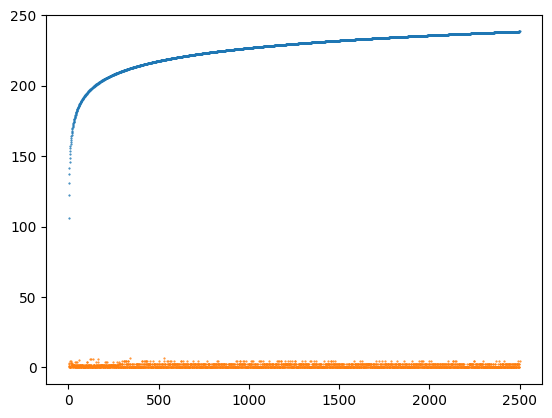

In [32]:


def obtain_probability(t , factor):

    sigma = 1/2
    K = 100
    epsilon = 10e-7

    def divide_interval(start, end, k):
        intervals = np.linspace(start, end, k).tolist()
        return intervals

    # U = np.sqrt( self.alpha  * np.log(t) ) 

    U =  factor
    rhos = divide_interval(0, U, K)
    p_m_hat =  np.array([ np.exp( -(rhos[i]**2) / 2*(sigma**2)  )  for i in range(len(rhos)-1) ] )
    p_m = (1 - epsilon) * p_m_hat / p_m_hat.sum()
    p_m = p_m.tolist()
    p_m.append(epsilon)
        
    Z = np.random.choice(rhos, p= p_m)
    return Z

deterministic = []
rand = []

for t in range(1, 2500):
    sigma_i = 2
    d = 730
    N = 3
    H = 50
    lbd_reg = 1
    factor = sigma_i * (  np.sqrt( 2 * ( d  * np.log( 1 + t * np.log(N * H)/lbd_reg ) +  np.log(1/t**2) ) ) + np.sqrt(lbd_reg) * sigma_i )
    rand_value = obtain_probability(t , factor)
    deterministic.append(factor)
    rand.append(rand_value)


plt.plot(range(1,2500), deterministic, '.', markersize = 1)

plt.plot(range(1,2500), rand, '.', markersize = 1)



(array([1.362e+03, 7.500e+02, 1.380e+02, 1.900e+01, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.290e+02]),
 array([0.        , 0.90886871, 1.81773743, 2.72660614, 3.63547486,
        4.54434357, 5.45321229, 6.362081  , 7.27094972, 8.17981843,
        9.08868714]),
 <BarContainer object of 10 artists>)

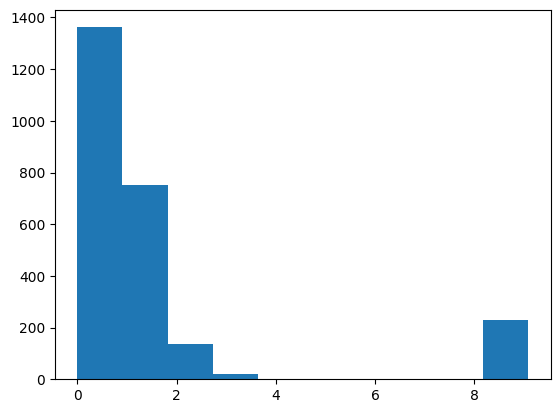

In [67]:
plt.hist(rand, bins = 10)

In [1]:
context_generator = synthetic_data.QuinticContexts(  )
context_generator.set_b(0)
context_generator.normalization()

V_it_inv = np.identity(20)

vals = []
rates = []

T = 10000

for t in range(1,T):

    norm_context, distribution = context_generator.get_context(True)
    dist_test.append(distribution)
    outcome = np.random.choice( 2 , p = distribution ) 

    latent_X = alg.func( torch.from_numpy( norm_context ).float().to(alg.device) ).cpu().detach().numpy()

    V_it_inv = V_it_inv - ( V_it_inv @ latent_X.T @ latent_X @ V_it_inv ) / ( 1 + latent_X @ V_it_inv @ latent_X.T ) 

    val =  latent_X @ V_it_inv @ latent_X.T  
    rate = t**(2/3)  * ( 1.01 * np.log(t) )**(1/3)

    vals.append(val[0][0])
    rates.append(1/rate)

plt.plot(range(1,T), vals, '.' , markersize = 0.01, color = 'blue', label = 'pseudo-count')
plt.plot(range(1,T), rates, '.', markersize = 0.01, color = 'red', label = 'exploration threshold')
plt.yscale('log')
plt.legend()

NameError: name 'synthetic_data' is not defined